# APC and GTFS analysis

In [1]:
import pandas as pd
import datetime
import glob,dateparser
import zipfile
import numpy as np

The analysis is done by year starting with 2021. The data comes from the `analysis_frame_gtfs_and_patterns.parquet` which can be found [here](https://www.dropbox.com/sh/mi6zymzax8fybno/AACkz546s2J31xDxNgph9ox6a/analysis_frame_with_gtfs_and_patterns.parquet?dl=0&subfolder_nav_tracking=1).


Step 1 delete the records that have NULL in the time_str column.

## Year 2021

In [2]:
#wego_2021 = pd.read_parquet('Data/Complete_Data/year=2021')
wego_2021 = pd.read_parquet('Cleaned_loads_wego_2021.parquet')
wego_2021.shape

(7864409, 43)

In [3]:
#•wego_2021.to_parquet('Data/wego_2021.parquet')

## 1. Delete where `time_str` is 'NULL"

In [3]:
wego_2021['time_str'].isnull().sum()

171405

There are 171405 rows with `NULL` values in the `time_str` field.

In [4]:
wego_2021[wego_2021['time_str'].isnull()].head()

,activation_date,activation_date_str,arrival_time,arrival_time_str,block_abbr,block_stop_order,day,deactivation_date,deactivation_date_str,gtfs_end_date,...,transit_date,transit_date_str,trip_id,trip_start_time,type_of_day,vehicle_capacity,vehicle_id,window_of_day,month,Neg_Load
655470,2021-08-25,08/25/21,NaT,None,1700,77,Friday,2021-10-02,10/02/21,2021-10-02,...,2021-10-01,10/01/21,241650,2021-10-01 07:15:00,weekday,40.0,1912,2,10,1.0
655600,2021-08-25,08/25/21,NaT,None,5604,316,Saturday,2021-10-02,10/02/21,2021-10-02,...,2021-10-02,10/02/21,240700,2021-10-02 15:35:00,weekend,45.0,188,4,10,14.0
655601,2021-08-25,08/25/21,NaT,None,5604,317,Saturday,2021-10-02,10/02/21,2021-10-02,...,2021-10-02,10/02/21,240700,2021-10-02 15:35:00,weekend,45.0,188,4,10,14.0
655647,2021-08-25,08/25/21,NaT,None,700,378,Saturday,2021-10-02,10/02/21,2021-10-02,...,2021-10-02,10/02/21,241104,2021-10-02 15:35:00,weekend,40.0,705,4,10,4.0
655648,2021-08-25,08/25/21,NaT,None,700,379,Saturday,2021-10-02,10/02/21,2021-10-02,...,2021-10-02,10/02/21,241104,2021-10-02 15:35:00,weekend,40.0,705,4,10,4.0


In [5]:
wego_2021_null_time_str = wego_2021[wego_2021['arrival_time'].isnull()]
wego_2021_null_time_str.to_parquet('Data/wego_2021_null_time_str.parquet')
del(wego_2021_null_time_str)

Updating `wego_2021` without `NULL` values:

In [6]:
wego_2021 = wego_2021.dropna(subset=['time_str'])
wego_2021.shape

(7693004, 43)

## 2. Negative loads

In [7]:
wego_2021_neg_load = wego_2021.groupby(['transit_date', 'trip_id'], as_index=False)['load'].min()
wego_2021_neg_load = wego_2021_neg_load.drop_duplicates()
wego_2021_neg_load.columns = ['transit_date', 'trip_id', 'neg_load']
wego_2021_neg_load.head()

,transit_date,trip_id,neg_load
0,2021-01-01,229493,1.0
1,2021-01-01,229494,2.0
2,2021-01-01,229495,1.0
3,2021-01-01,229496,3.0
4,2021-01-01,229497,1.0


In [10]:
wego_2021 = pd.merge(wego_2021, wego_2021_neg_load, how = 'left', on = ['transit_date', 'trip_id'])
wego_2021.head()

,activation_date,activation_date_str,arrival_time,arrival_time_str,block_abbr,block_stop_order,day,deactivation_date,deactivation_date_str,gtfs_end_date,...,transit_date_str,trip_id,trip_start_time,type_of_day,vehicle_capacity,vehicle_id,window_of_day,month,Neg_Load,neg_load
0,2020-11-17,11/17/20,2021-01-01 14:00:11,14:00:11,2200,535,Friday,2021-02-17,02/17/21,2021-04-03,...,01/01/21,230139,2021-01-01 13:48:00,weekday,15.0,1800,4,1,2.0,2.0
1,2020-11-17,11/17/20,2021-01-01 14:00:34,14:00:34,2200,536,Friday,2021-02-17,02/17/21,2021-04-03,...,01/01/21,230139,2021-01-01 13:48:00,weekday,15.0,1800,4,1,2.0,2.0
2,2020-11-17,11/17/20,2021-01-01 14:00:40,14:00:40,2200,537,Friday,2021-02-17,02/17/21,2021-04-03,...,01/01/21,230139,2021-01-01 13:48:00,weekday,15.0,1800,4,1,2.0,2.0
3,2020-11-17,11/17/20,2021-01-01 14:01:00,14:01:00,2200,538,Friday,2021-02-17,02/17/21,2021-04-03,...,01/01/21,230139,2021-01-01 13:48:00,weekday,15.0,1800,4,1,2.0,2.0
4,2020-11-17,11/17/20,2021-01-01 14:01:18,14:01:18,2200,539,Friday,2021-02-17,02/17/21,2021-04-03,...,01/01/21,230139,2021-01-01 13:48:00,weekday,15.0,1800,4,1,2.0,2.0


In [11]:
wego_2021 = wego_2021[wego_2021['neg_load'] >= 0]
wego_2021.shape

(7693004, 44)

There are 7693004 records with consist `load` values.

In [12]:
wego_2021[wego_2021['load'] < 0].shape

(0, 44)

There are 0 rows with negative loads (or negative occupancies). 

## 2. Positive -and zero- loads

Confirming that there are 7693004 records with consist `load` values.

In [13]:
wego_2021 = wego_2021[wego_2021['load'] >= 0]
wego_2021.shape

(7693004, 44)

In [15]:
wego_2021.head()

,activation_date,activation_date_str,arrival_time,arrival_time_str,block_abbr,block_stop_order,day,deactivation_date,deactivation_date_str,gtfs_end_date,...,transit_date,transit_date_str,trip_id,trip_start_time,type_of_day,vehicle_capacity,vehicle_id,window_of_day,month,Neg_Load
0,2020-11-17T00:00:00Z,11/17/20,2021-01-01T14:00:11Z,14:00:11,2200,535,Friday,2021-02-17T00:00:00Z,02/17/21,2021-04-03T00:00:00Z,...,2021-01-01T00:00:00Z,01/01/21,230139,2021-01-01T13:48:00Z,weekday,15.0,1800,4,1,2
1,2020-11-17T00:00:00Z,11/17/20,2021-01-01T14:00:34Z,14:00:34,2200,536,Friday,2021-02-17T00:00:00Z,02/17/21,2021-04-03T00:00:00Z,...,2021-01-01T00:00:00Z,01/01/21,230139,2021-01-01T13:48:00Z,weekday,15.0,1800,4,1,2
2,2020-11-17T00:00:00Z,11/17/20,2021-01-01T14:00:40Z,14:00:40,2200,537,Friday,2021-02-17T00:00:00Z,02/17/21,2021-04-03T00:00:00Z,...,2021-01-01T00:00:00Z,01/01/21,230139,2021-01-01T13:48:00Z,weekday,15.0,1800,4,1,2
3,2020-11-17T00:00:00Z,11/17/20,2021-01-01T14:01:00Z,14:01:00,2200,538,Friday,2021-02-17T00:00:00Z,02/17/21,2021-04-03T00:00:00Z,...,2021-01-01T00:00:00Z,01/01/21,230139,2021-01-01T13:48:00Z,weekday,15.0,1800,4,1,2
4,2020-11-17T00:00:00Z,11/17/20,2021-01-01T14:01:18Z,14:01:18,2200,539,Friday,2021-02-17T00:00:00Z,02/17/21,2021-04-03T00:00:00Z,...,2021-01-01T00:00:00Z,01/01/21,230139,2021-01-01T13:48:00Z,weekday,15.0,1800,4,1,2


In [14]:
wego_2021.dtypes

activation_date          datetime64[ns]
activation_date_str              object
arrival_time             datetime64[ns]
arrival_time_str                 object
block_abbr                        int32
block_stop_order                  int32
day                              object
deactivation_date        datetime64[ns]
deactivation_date_str            object
gtfs_end_date            datetime64[ns]
gtfs_file                        object
gtfs_start_date          datetime64[ns]
hour_of_trip                      int32
load                            float64
load_factor                     float64
map_latitude                    float64
map_longitude                   float64
offs                            float64
ons                             float64
pattern_num                      object
route_direction_name             object
route_id                          int32
scheduled_time           datetime64[ns]
scheduled_time_str               object
service_id                       object


In [28]:
wego_2021.columns

Index(['activation_date', 'activation_date_str', 'arrival_time',
       'arrival_time_str', 'block_abbr', 'block_stop_order', 'day',
       'deactivation_date', 'deactivation_date_str', 'gtfs_end_date',
       'gtfs_file', 'gtfs_start_date', 'hour_of_trip', 'load', 'load_factor',
       'map_latitude', 'map_longitude', 'offs', 'ons', 'pattern_num',
       'route_direction_name', 'route_id', 'scheduled_time',
       'scheduled_time_str', 'service_id', 'shape_id', 'stop_id',
       'stop_id_list', 'stop_name', 'stop_sequence', 'stop_sequence_list',
       'time', 'time_str', 'transit_date', 'transit_date_str', 'trip_id',
       'trip_start_time', 'type_of_day', 'vehicle_capacity', 'vehicle_id',
       'window_of_day', 'month', 'Neg_Load'],
      dtype='object')

There are 11660 different `trip_id` values in the `wego_2021` dataset:

In [15]:
wego_2021['trip_id'].nunique()

11660

## 3. test if the hour of the time is adjusted to 0-23 incase a trip crosses two days

In [16]:
wego_2021.hour_of_trip.value_counts()

16    582230
15    535965
14    525546
10    509718
12    504520
13    481761
17    480428
8     473084
11    468856
7     466435
9     446093
6     440264
18    431771
19    358564
20    324410
21    260765
5     189766
22    152817
23     35981
4      20999
0       3031
Name: hour_of_trip, dtype: int64

Yes, the hour values are adjusted to 0-23.

### 3.1 if the hour is adjusted to 0-23, test if the date is also updated when the vehicle enters the next day during that trip.

A trip can only serve once per date, so if the `pattern_num` is fixed, it should visit the same number bus stops per date.

In [17]:
trips_and_dates = wego_2021.groupby(['trip_id', 'transit_date', 'pattern_num'])['stop_id', 'vehicle_id'].count().reset_index()
trips_and_dates.head()

C:\Users\jcmar\AppData\Local\Temp/ipykernel_18544/4205379703.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  trips_and_dates = wego_2021.groupby(['trip_id', 'transit_date', 'pattern_num'])['stop_id', 'vehicle_id'].count().reset_index()


,trip_id,transit_date,pattern_num,stop_id,vehicle_id
0,229457,2021-01-09,ROUTE_14_FROM DOWNTOWN_2,43,43
1,229457,2021-01-16,ROUTE_14_FROM DOWNTOWN_2,43,43
2,229457,2021-01-18,ROUTE_14_FROM DOWNTOWN_2,43,43
3,229457,2021-01-23,ROUTE_14_FROM DOWNTOWN_2,43,43
4,229457,2021-01-30,ROUTE_14_FROM DOWNTOWN_2,43,43


## 4. test if a trip_id is assigned to multiple routes in the APC data

We already know that there are 11660 `trip_id` values during 2021. So we only have to group by `trip_id` and then count the different number of `route_id` values that are associated to that `trip_id`. If the returned value is `1`, then we can conclude that the trip is assigned to only one `route_id`.

In [18]:
trips_and_routes = wego_2021.groupby(['trip_id'], as_index = False)['route_id', 'route_direction_name'].nunique()
trips_and_routes

C:\Users\jcmar\AppData\Local\Temp/ipykernel_18544/2056836698.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  trips_and_routes = wego_2021.groupby(['trip_id'], as_index = False)['route_id', 'route_direction_name'].nunique()


,trip_id,route_id,route_direction_name
0,229457,1,1
1,229458,1,1
2,229459,1,1
3,229460,1,1
4,229461,1,1
...,...,...,...
11655,264830,1,1
11656,264831,1,1
11657,264834,1,1
11658,264839,1,1


In [19]:
trips_and_routes[trips_and_routes['route_id'] > 1]

,trip_id,route_id,route_direction_name


Finally, we conclude that each trip is assigned to only one `route_id` and `route_direction_name`.

## 5. test for null required values (usually load and/or time)

* `arrival_time`


In [20]:
wego_2021['arrival_time'].isnull().sum()

344673

There are 344673 rows with `NULL` values in their `arrival_time` field.

* `load`

In [21]:
wego_2021['load'].isnull().sum()

0

All the rows have their respective `load` value.

In [22]:
wego_2021[wego_2021['arrival_time'].isnull()].head()

,activation_date,activation_date_str,arrival_time,arrival_time_str,block_abbr,block_stop_order,day,deactivation_date,deactivation_date_str,gtfs_end_date,...,transit_date_str,trip_id,trip_start_time,type_of_day,vehicle_capacity,vehicle_id,window_of_day,month,Neg_Load,neg_load
19,2020-11-17,11/17/20,NaT,NULL,2200,554,Friday,2021-02-17,02/17/21,2021-04-03,...,01/01/21,230139,2021-01-01 13:48:00,weekday,15.0,1800,4,1,2.0,2.0
20,2020-11-17,11/17/20,NaT,NULL,2200,555,Friday,2021-02-17,02/17/21,2021-04-03,...,01/01/21,230139,2021-01-01 13:48:00,weekday,15.0,1800,4,1,2.0,2.0
21,2020-11-17,11/17/20,NaT,NULL,2200,556,Friday,2021-02-17,02/17/21,2021-04-03,...,01/01/21,230139,2021-01-01 13:48:00,weekday,15.0,1800,4,1,2.0,2.0
22,2020-11-17,11/17/20,NaT,NULL,2200,557,Friday,2021-02-17,02/17/21,2021-04-03,...,01/01/21,230139,2021-01-01 13:48:00,weekday,15.0,1800,4,1,2.0,2.0
23,2020-11-17,11/17/20,NaT,NULL,2200,558,Friday,2021-02-17,02/17/21,2021-04-03,...,01/01/21,230139,2021-01-01 13:48:00,weekday,15.0,1800,4,1,2.0,2.0


We save this dataset for further analysis:

In [23]:
wego_2021_null_arrival_time = wego_2021[wego_2021['arrival_time'].isnull()]
wego_2021_null_arrival_time.to_parquet('Data/wego_2021_null_arrival_time.parquet')
del(wego_2021_null_arrival_time)

wego_2021 = wego_2021.dropna(subset=['arrival_time'])
wego_2021.shape

(7348331, 44)

## 6. test the drift between the percentage computed using the typical `vehicle_capacity` and the `capacity` for that trip at that specific day

In [24]:
trip_capacity_by_date = wego_2021.groupby(['transit_date', 'trip_id', 'vehicle_capacity'], as_index = False)['load', 'load_factor'].max()
trip_capacity_by_date['corrected_load_factor'] = trip_capacity_by_date['load']/trip_capacity_by_date['vehicle_capacity']
trip_capacity_by_date.head()

C:\Users\jcmar\AppData\Local\Temp/ipykernel_18544/3564252556.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  trip_capacity_by_date = wego_2021.groupby(['transit_date', 'trip_id', 'vehicle_capacity'], as_index = False)['load', 'load_factor'].max()


,transit_date,trip_id,vehicle_capacity,load,load_factor,corrected_load_factor
0,2021-01-01,229493,15.0,2.0,0.133333,0.133333
1,2021-01-01,229494,15.0,5.0,0.333333,0.333333
2,2021-01-01,229495,15.0,1.0,0.066666,0.066667
3,2021-01-01,229496,15.0,3.0,0.200000,0.200000
4,2021-01-01,229497,15.0,3.0,0.200000,0.200000


In [25]:
trip_capacity_by_date[trip_capacity_by_date['load_factor'].round(2) != trip_capacity_by_date['corrected_load_factor'].round(2)]

,transit_date,trip_id,vehicle_capacity,load,load_factor,corrected_load_factor


The `load_factor` value is computed correctly.

Let's check if there are `trip_id` that registered `load` values greater than the their respective `vehicle_capacity` values.

In [26]:
trip_capacity_by_date[(trip_capacity_by_date['load'] >= trip_capacity_by_date['vehicle_capacity'])].shape

(76569, 6)

Indeed, there are 76569 rows that indicate a `load` value greater than the its respective `vehicle_capacity`:

In [27]:
trip_capacity_by_date[(trip_capacity_by_date['load'] >= trip_capacity_by_date['vehicle_capacity'])].head()

,transit_date,trip_id,vehicle_capacity,load,load_factor,corrected_load_factor
16,2021-01-01,229616,15.0,21.0,1.400000,1.400000
18,2021-01-01,229618,15.0,19.0,1.266666,1.266667
20,2021-01-01,229620,15.0,15.0,1.000000,1.000000
22,2021-01-01,229622,15.0,23.0,1.533333,1.533333
57,2021-01-01,229850,15.0,26.0,1.733333,1.733333


In [28]:
trip_capacity_by_date.to_parquet('Data/trip_capacity_by_date_abnormal_loads.parquet')

In [29]:
wego_2021_abnormal_loads = wego_2021[wego_2021['load_factor'] > 1]
wego_2021_abnormal_loads.to_parquet('Data/wego_2021_abnormal_loads.parquet')
del(wego_2021_abnormal_loads)

## test the amount of APC samples that contain non useful data

* Remove the rows with `NaN` or `NULL` values:

In [30]:
wego_2021 = wego_2021.dropna()
wego_2021.shape

(7313277, 44)

* Remove rows with `load_factor > 1`:

In [31]:
wego_2021 = wego_2021[wego_2021['load_factor'] <= 1]
wego_2021.shape

(5833365, 44)

In [32]:
wego_2021.to_parquet('Data/wego_2021.parquet')

In [33]:
wego_2021['load'].max()

45.0

## 7. test the APC coverage by day

<AxesSubplot:xlabel='transit_date'>

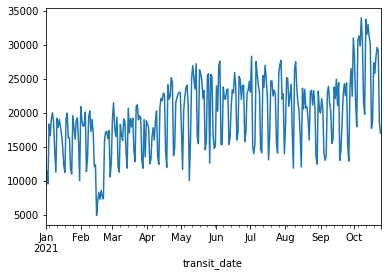

In [49]:
coverage_2021 = wego_2021.groupby(['transit_date', 'trip_id'], as_index=False)['stop_id'].count()
coverage_2021_ts = pd.Series(coverage_2021.groupby(['transit_date'])['stop_id'].sum())
coverage_2021_ts.plot()

In [54]:
del(wego_2021)

## Year 2020

In [2]:
wego_2020 = pd.read_parquet('Data/Complete_Data/year=2020')
wego_2020.shape

(18679862, 42)

There is a total of 18937482 rows in the main dataframe.

## 1. Negative loads

In [3]:
wego_2020_neg_load = wego_2020.groupby(['transit_date', 'trip_id'], as_index=False)['load'].min()
wego_2020_neg_load = wego_2020_neg_load.drop_duplicates()
wego_2020_neg_load.columns = ['transit_date', 'trip_id', 'neg_load']
wego_2020_neg_load.head()

,transit_date,trip_id,neg_load
0,2020-01-01,193712,-2.0
1,2020-01-01,193713,-1.0
2,2020-01-01,193714,-2.0
3,2020-01-01,193715,0.0
4,2020-01-01,193716,4.0


In [4]:
wego_2020_neg_load['neg_load'].max()

2704.0

In [5]:
wego_2020 = pd.merge(wego_2020, wego_2020_neg_load, how = 'left', on = ['transit_date', 'trip_id'])
wego_2020.head()

,activation_date,activation_date_str,arrival_time,arrival_time_str,block_abbr,block_stop_order,day,deactivation_date,deactivation_date_str,gtfs_end_date,...,transit_date,transit_date_str,trip_id,trip_start_time,type_of_day,vehicle_capacity,vehicle_id,window_of_day,month,neg_load
0,2019-10-27,10/27/19,2020-01-01 14:00:20,14:00:20,300,628,Wednesday,2020-03-11,03/11/20,2020-01-23,...,2020-01-01,01/01/20,195848,2020-01-01 14:15:00,weekday,15.0,718,4,1,-2.0
1,2019-10-27,10/27/19,NaT,NULL,300,629,Wednesday,2020-03-11,03/11/20,2020-01-23,...,2020-01-01,01/01/20,195848,2020-01-01 14:15:00,weekday,15.0,718,4,1,-2.0
2,2019-10-27,10/27/19,2020-01-01 14:20:38,14:20:38,300,630,Wednesday,2020-03-11,03/11/20,2020-01-23,...,2020-01-01,01/01/20,195848,2020-01-01 14:15:00,weekday,15.0,718,4,1,-2.0
3,2019-10-27,10/27/19,2020-01-01 14:21:44,14:21:44,300,631,Wednesday,2020-03-11,03/11/20,2020-01-23,...,2020-01-01,01/01/20,195848,2020-01-01 14:15:00,weekday,15.0,718,4,1,-2.0
4,2019-10-27,10/27/19,2020-01-01 14:24:20,14:24:20,300,632,Wednesday,2020-03-11,03/11/20,2020-01-23,...,2020-01-01,01/01/20,195848,2020-01-01 14:15:00,weekday,15.0,718,4,1,-2.0


In [6]:
#del(wego)
wego_2020 = wego_2020[wego_2020['neg_load'] >= 0]
wego_2020.shape

(8209611, 43)

In [7]:
wego_2020['load'].min()

0.0

In [8]:
#wego_2020_neg_load.to_parquet('wego_2020_neg_load.parquet')
#del(wego_2020_neg_load)

There are 8209611 whose loads (trips grouped by date actually) did not have negative values:

## 3. test if the hour of the time is adjusted to 0-23 incase a trip crosses two days

In [10]:
wego_2020['hour_of_trip'].value_counts()

16    617737
15    561216
14    546709
10    525709
17    518699
12    515988
6     500801
13    491136
8     485879
7     485416
11    476930
18    469414
9     463520
19    381577
20    336868
21    264245
5     227698
22    130331
4      37025
23     21653
Name: hour_of_trip, dtype: int64

Yes, the hour values are adjusted to 0-23.

In [ ]:
#wego_2020['hour'] = wego_2020['arrival_time'].dt.hour
#wego_2021.to_parquet('Data/wego_2021.parquet')

### 3.1 if the hour is adjusted to 0-23, test if the date is also updated when the vehicle enters the next day during that trip.

A trip can only serve once per date, so if the `pattern_num` is fixed, it should visit the same number bus stops per date.

In [11]:
trips_and_dates = wego_2020.groupby(['trip_id', 'transit_date', 'pattern_num'])['stop_id', 'vehicle_id'].count().reset_index()
trips_and_dates.head()

C:\Users\jcmar\AppData\Local\Temp/ipykernel_17572/4043615288.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  trips_and_dates = wego_2020.groupby(['trip_id', 'transit_date', 'pattern_num'])['stop_id', 'vehicle_id'].count().reset_index()


,trip_id,transit_date,pattern_num,stop_id,vehicle_id
0,193637,2020-01-28,ROUTE_14_FROM DOWNTOWN_0,31,31
1,193637,2020-02-07,ROUTE_14_FROM DOWNTOWN_0,27,27
2,193637,2020-02-17,ROUTE_14_FROM DOWNTOWN_0,42,42
3,193637,2020-02-21,ROUTE_14_FROM DOWNTOWN_0,43,43
4,193637,2020-02-28,ROUTE_14_FROM DOWNTOWN_0,42,42


## 4. test if a trip_id is assigned to multiple routes in the APC data

We already know that there are 11915 `trip_id` values during 2021. So we only have to group by `trip_id` and then count the different number of `route_id` values that are associated to that `trip_id`. If the returned value is `1`, then we can conclude that the trip is assigned to only one `route_id`.

In [12]:
trips_and_routes = wego_2020.groupby(['trip_id'], as_index = False)['route_id', 'route_direction_name'].nunique()
trips_and_routes

C:\Users\jcmar\AppData\Local\Temp/ipykernel_17572/2770971446.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  trips_and_routes = wego_2020.groupby(['trip_id'], as_index = False)['route_id', 'route_direction_name'].nunique()


,trip_id,route_id,route_direction_name
0,193637,1,1
1,193638,1,1
2,193639,1,1
3,193640,1,1
4,193641,1,1
...,...,...,...
19612,237546,1,1
19613,237547,1,1
19614,237548,1,1
19615,237549,1,1


In [13]:
trips_and_routes[trips_and_routes['route_id'] > 1]

,trip_id,route_id,route_direction_name


Finally, we conclude that each trip is assigned to only one `route_id` and `route_direction_name`.

## 5. test for null required values (usually load and/or time)

* `arrival_time`

In [14]:
wego_2020['arrival_time'].isnull().sum()

479799

There are 479799 rows with `NULL` values in their `arrival_time` field.

* `load`

In [15]:
wego_2020['load'].isnull().sum()

0

All rows have their respective `load` values.

In [16]:
wego_2020[wego_2020['arrival_time'].isnull()].head()

,activation_date,activation_date_str,arrival_time,arrival_time_str,block_abbr,block_stop_order,day,deactivation_date,deactivation_date_str,gtfs_end_date,...,transit_date,transit_date_str,trip_id,trip_start_time,type_of_day,vehicle_capacity,vehicle_id,window_of_day,month,neg_load
75,2019-10-27,10/27/19,NaT,NULL,5503,151,Wednesday,2020-03-11,03/11/20,2020-01-23,...,2020-01-01,01/01/20,203699,2020-01-01 10:12:00,weekday,25.0,141,3,1,87.0
76,2019-10-27,10/27/19,NaT,NULL,5503,152,Wednesday,2020-03-11,03/11/20,2020-01-23,...,2020-01-01,01/01/20,203699,2020-01-01 10:12:00,weekday,25.0,141,3,1,87.0
503,2019-10-27,10/27/19,NaT,NULL,1803,167,Friday,2020-03-11,03/11/20,2020-01-23,...,2020-01-03,01/03/20,194157,2020-01-03 20:47:00,weekday,15.0,1804,6,1,2.0
504,2019-10-27,10/27/19,NaT,NULL,1803,168,Friday,2020-03-11,03/11/20,2020-01-23,...,2020-01-03,01/03/20,194157,2020-01-03 20:47:00,weekday,15.0,1804,6,1,2.0
505,2019-10-27,10/27/19,NaT,NULL,1803,169,Friday,2020-03-11,03/11/20,2020-01-23,...,2020-01-03,01/03/20,194157,2020-01-03 20:47:00,weekday,15.0,1804,6,1,2.0


In [17]:
wego_2020 = wego_2020.dropna(subset=['arrival_time'])
wego_2020.shape

(7578752, 43)

We save this for further analysis:

In [18]:
wego_2020_null_arrival_time = wego_2020[wego_2020['arrival_time'].isnull()]
wego_2020_null_arrival_time.to_parquet('Data/wego_2020_null_arrival_time.parquet')
del(wego_2020_null_arrival_time)

## 6. test the drift between the percentage computed using the typical `vehicle_capacity` and the `capacity` for that trip at that specific day

In [19]:
trip_capacity_by_date = wego_2020.groupby(['transit_date', 'trip_id', 'vehicle_capacity'], as_index = False)['load', 'load_factor'].max()
trip_capacity_by_date['corrected_load_factor'] = trip_capacity_by_date['load']/trip_capacity_by_date['vehicle_capacity']
trip_capacity_by_date.head()

C:\Users\jcmar\AppData\Local\Temp/ipykernel_17572/2077034394.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  trip_capacity_by_date = wego_2020.groupby(['transit_date', 'trip_id', 'vehicle_capacity'], as_index = False)['load', 'load_factor'].max()


,transit_date,trip_id,vehicle_capacity,load,load_factor,corrected_load_factor
0,2020-01-01,193715,15.0,9.0,0.600000,0.600000
1,2020-01-01,193716,15.0,13.0,0.866666,0.866667
2,2020-01-01,193717,15.0,0.0,0.000000,0.000000
3,2020-01-01,193718,15.0,4.0,0.266666,0.266667
4,2020-01-01,193719,15.0,3.0,0.200000,0.200000


In [20]:
trip_capacity_by_date[trip_capacity_by_date['load_factor'].round(2) != trip_capacity_by_date['corrected_load_factor'].round(2)]

,transit_date,trip_id,vehicle_capacity,load,load_factor,corrected_load_factor


The `load_factor` value is computed correctly.

Let's check if there are `trip_id` that registered `load` values greater than the their respective `vehicle_capacity` values.

In [21]:
trip_capacity_by_date[(trip_capacity_by_date['load'] >= trip_capacity_by_date['vehicle_capacity'])].shape

(102785, 6)

Indeed, there are 102785 rows that indicate a `load` value greater than the its respective `vehicle_capacity`:

In [22]:
trip_capacity_by_date[(trip_capacity_by_date['load'] >= trip_capacity_by_date['vehicle_capacity'])].head()

,transit_date,trip_id,vehicle_capacity,load,load_factor,corrected_load_factor
10,2020-01-01,194410,15.0,16.0,1.066666,1.066667
16,2020-01-01,194416,15.0,15.0,1.000000,1.000000
19,2020-01-01,194420,15.0,16.0,1.066666,1.066667
20,2020-01-01,194421,15.0,16.0,1.066666,1.066667
21,2020-01-01,194422,15.0,16.0,1.066666,1.066667


In [24]:
trip_capacity_by_date.to_parquet('Data/trip_capacity_by_date_abnormal_loads_2020.parquet')
del(trip_capacity_by_date)

In [25]:
wego_2020_abnormal_loads = wego_2020[wego_2020['load_factor'] > 1]
wego_2020_abnormal_loads.to_parquet('Data/wego_2020_abnormal_loads.parquet')
del(wego_2020_abnormal_loads)

In [26]:
wego_2020.to_parquet('Data/wego_2020.parquet')

## 7. test the APC coverage by day

<AxesSubplot:xlabel='transit_date'>

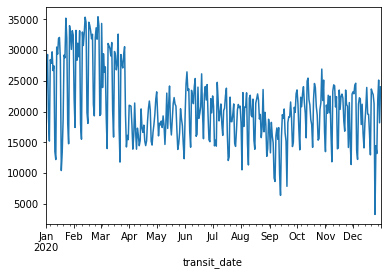

In [27]:
coverage_2020 = wego_2020.groupby(['transit_date', 'trip_id'], as_index=False)['stop_id'].count()
coverage_2020_ts = pd.Series(coverage_2020.groupby(['transit_date'])['stop_id'].sum())
coverage_2020_ts.plot()